## sklearn has tons of good info on p >> n linear regression on their User Guide: 
https://scikit-learn.org/stable/modules/linear_model.html

### LASSO (and LASSO CV)
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV

### Lars (Least-angle regression)

> LARS is similar to forward stepwise regression. At each step, it finds the feature most correlated with the target. When there are multiple features having equal correlation, instead of continuing along the same feature, it proceeds in a direction equiangular between the features.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lars.html#sklearn.linear_model.Lars
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsCV.html#sklearn.linear_model.LassoLarsCV
####  Lars LASSO is another thing, but:
> The object solves the same problem as the LassoCV object. However, unlike the LassoCV, it find the relevant alphas values by itself. In general, because of this property, it will be more stable. **However, it is more fragile to heavily multicollinear datasets.**


### Very readable LASSO explanation from Cambridge Statslab
http://www.statslab.cam.ac.uk/~rds37/papers/Lasso_Rajen_Shah.pdf

### The Clustergroup LASSO method sounds promising, but no codebase is given
http://www.statslab.cam.ac.uk/~rds37/papers/Shah%20Samworth%202013%20Discussion%20of%20correlated%20variables%20in%20regression%20-%20clustering%20and%20sparse%20estimation.pdf



In [5]:
import time
from collections import defaultdict
import json
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LarsCV, LassoCV, LinearRegression, RidgeCV, Lasso

from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,)
from sklearn.model_selection import (
    cross_val_score, cross_val_predict, cross_validate,
    RepeatedKFold, RepeatedStratifiedKFold, 
    StratifiedGroupKFold, GroupKFold, StratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,)

import sklearn
print(sklearn.__version__)

1.0.2


In [3]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

In [4]:
X_all = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)

y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

# Comparing linear regression models trained on fed versus fasted data

In [142]:
cv_10 = RepeatedKFold(n_splits=10, n_repeats=30, random_state=1)
model = Lasso()
rbg_scores = cross_val_score(
    model,       
    X_all.loc[rbg_cols],  
    y_ogtt.loc[rbg_cols],  
    scoring='neg_mean_absolute_percentage_error',          
    cv=cv_10,            
    n_jobs=7,      
    error_score='raise')

fbg_scores = cross_val_score(
    model,       
    X_all.loc[fbg_cols],  
    y_ogtt.loc[fbg_cols],  
    scoring='neg_mean_absolute_percentage_error',          
    cv=cv_10,            
    n_jobs=7,      
    error_score='raise')

Mean Error:   0.13419200272349077
Median Error: 0.11913481107535533
Standard Dev of errors: 		0.0810417423700447


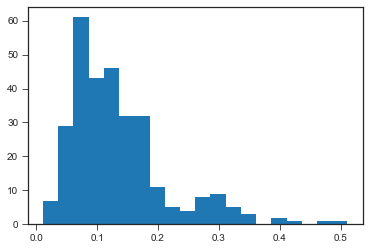

In [143]:
print(f'Mean Error:   {np.mean(-1*rbg_scores)}\n'
      f'Median Error: {np.median(-1*rbg_scores)}\n'
      f'Standard Dev of errors: \t\t{np.std(rbg_scores)}')
plt.hist(-1*rbg_scores, bins=20);

In [147]:
mean_rbg = np.mean(-1 * rbg_scores)
mean_fbg = np.mean(-1 * fbg_scores)
median_rbg = np.median(-1 * rbg_scores)
median_fbg = np.median(-1 * fbg_scores)

errors = pd.DataFrame({'FBG': fbg_scores*-1, 'RBG': rbg_scores*-1}).melt()
errors['dummy'] = 'dummy'
errors.to_csv(r'../data/interim/fasted_vs_fed_model_errors/LASSO.csv')

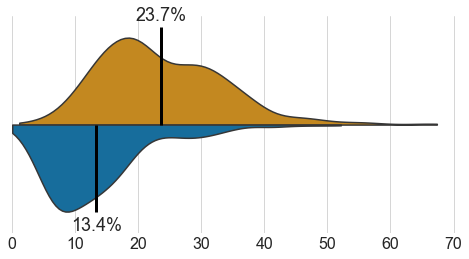

In [146]:
fig, ax = plt.subplots(figsize=(8, 4))

vp = sns.violinplot(
    data=errors, x='value', y='dummy',
    orient='h', split=True, hue='variable',
    scale='width', cut=0.4,
    palette=colors, 
    inner=None, 
    ax=ax
)
plt.axvline(x=mean_fbg, ymin=0.5, ymax=0.95, c='black', linewidth=3, solid_capstyle='butt')
plt.axvline(x=mean_rbg, ymin=0.1, ymax=0.5, c='black', linewidth=3, solid_capstyle='butt')
plt.annotate(text=str(round(mean_fbg*100, 1)) + '%', xy=(mean_fbg, plt.ylim()[1]), 
             ha='center', va='center', fontsize=18, )
plt.annotate(text=str(round(mean_rbg*100, 1)) + '%', xy=(mean_rbg, plt.ylim()[0]*0.93), 
             ha='center', va='center', fontsize=18)

ax.set_yticks([])
ax.set_xlim((0, ax.get_xlim()[1]))
# ax.set_xticks(ticks=ax.get_xticks()[:-1], labels=[int(x*100) for x in ax.get_xticks()][:-1], fontsize=16)
ax.set_xticks(ticks=np.arange(0, 0.75, 0.1), labels=range(0, 80, 10), fontsize=16)
ax.tick_params(axis='x', length=0)
ax.set_ylabel(None)
ax.set_xlabel(None)

ax.get_legend().remove()
plt.grid()

sns.despine(left=True, bottom=True, ax=ax)

plt.savefig(r'../reports/figures/fasted_vs_fed_models/lasso.png', bbox_inches='tight', dpi=150)
plt.savefig(r'../reports/figures/fasted_vs_fed_models/lasso.svg', bbox_inches='tight', dpi=150)

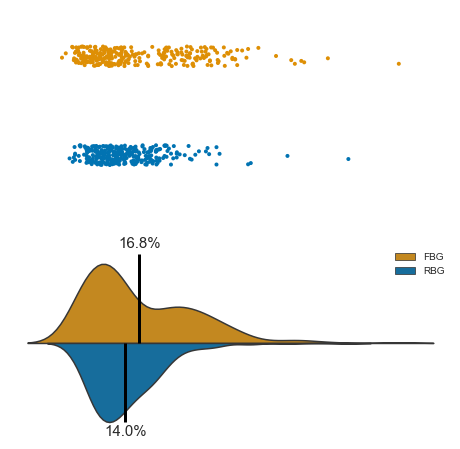

In [67]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8, 8))
sp = sns.stripplot(
    data=errors, x='value', y='variable',
    s=4, palette=colors, ax=ax1
)

vp = sns.violinplot(
    data=errors, x='value', y='dummy',
    orient='h', split=True, hue='variable',
    scale='width',
    palette=colors, 
    inner=None, 
    ax=ax2
)
# plt.plot([mean_rbg, mean_rbg], [0, 100])
plt.axvline(x=mean_fbg, ymin=0.5, ymax=0.95, c='black', linewidth=3, solid_capstyle='butt')
plt.axvline(x=mean_rbg, ymin=0.1, ymax=0.5, c='black', linewidth=3, solid_capstyle='butt')
plt.annotate(text=str(round(mean_fbg*100, 1)) + '%', xy=(mean_fbg, plt.ylim()[1]), 
             ha='center', va='center', fontsize=15, )
plt.annotate(text=str(round(mean_rbg*100, 1)) + '%', xy=(mean_rbg, plt.ylim()[0]*0.9), 
             ha='center', va='center', fontsize=15)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel(None)
ax1.set_ylabel(None)

ax2.set_yticks([])
ax2.set_ylabel(None)
ax2.set_xlabel(None)

legend = vp.legend_
legend.set_title(None)
# legend.

sns.despine(left=True, bottom=True, ax=ax1, fig=fig)

# ax2.legend(labels=['Fasted', 'Fed'])

# sns.despine(left=True)

In [ ]:
legend.

(array([ 67., 105.,  30.,  51.,  29.,  11.,   3.,   3.,   0.,   1.]),
 array([0.01442768, 0.08120466, 0.14798164, 0.21475861, 0.28153559,
        0.34831257, 0.41508954, 0.48186652, 0.5486435 , 0.61542048,
        0.68219745]),
 <BarContainer object of 10 artists>)

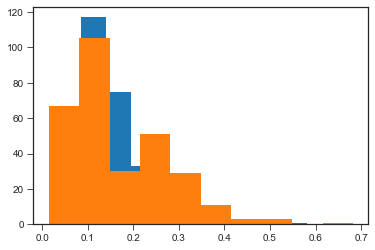

In [108]:
plt.hist(
    errors.loc[errors['variable'] == 'RBG', 'value'],
#     orientation='vertical',
)

plt.hist(
    errors.loc[errors['variable'] == 'FBG', 'value'] 
)


In [62]:
legend.get_texts()[0]

Text(0, 0, 'FBG')

## LassoCV 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

In [6]:
lcvd = {}  # lasso CV dictionary

for columns, bg_type in zip([rbg_cols, fbg_cols], ['RBG', 'FBG']):
    lcvd[bg_type] = {}
    for y_data, y_name in zip([y_ogtt], ['ogtt']):
        X = X_all.loc[columns]
        y = y_data.loc[columns]
        logo = list(LeaveOneGroupOut().split(X, y, groups=X.index.map(fg['animal'])))
        lcv = LassoCV(cv=logo,
                      max_iter=10000, fit_intercept=False,
                      n_jobs=-1, random_state=1).fit(X, y)
        lcvd[bg_type][y_name] = lcv

In [7]:
rom = lcvd['RBG']['ogtt']  # rom = RBG OGTT model
fom = lcvd['RBG']['ogtt']
rom

LassoCV(cv=[(array([ 1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 22, 23, 24, 25, 26, 27, 28, 29]),
             array([ 0,  3, 21])),
            (array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 25, 27, 28, 29]),
             array([ 4, 24, 26])),
            (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 14, 15, 16, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
             array([11, 13, 17])),
            (array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13,...
            (array([ 0,  1,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 26, 27, 28, 29]),
             array([ 2,  9, 25])),
            (array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 23, 24, 25, 26, 28, 29]),
             array([ 6, 22, 27])),
            (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 1

In [8]:
lfi = pd.DataFrame({'RBG': rom.coef_, 'FBG': fom.coef_}, index=rom.feature_names_in_).join(data)
lfifilt = lfi.loc[(lfi['RBG'] > 0) | (lfi['FBG'] > 0)]
lfifilt

,RBG,FBG,Unique ID,Type,Proposed ID,Found in Tracefinder,Compound Class,m/z,RT [min],Area (Max.),...,1092_10_FBG,1082_8_RBG,1062_8_RBG,1102_10_FBG,1093_8_RBG,1074_9_FBG,1062_9_RBG,1101_8_RBG,1092_8_RBG,1092_10_RBG
l_316,200.513246,200.513246,unknown_403.35858_8.542,lipid,unknown,NaN,unknown,403.35858,8.542,22.503550,...,15.679468,20.143520,21.094037,15.480311,19.911994,14.720615,20.570435,19.738191,21.011654,20.099443
l_758,33.652480,33.652480,unknown_1022.81708_15.216,lipid,unknown,NaN,unknown,1022.81708,15.216,21.354210,...,14.206143,18.060288,19.955390,16.491573,13.484304,14.581983,18.285860,17.179826,13.458281,14.073272
m_295,107.154032,107.154032,unknown_401.07464_11.572,metabolite,unknown,NaN,unknown,401.07464,11.572,24.344364,...,20.795106,23.566199,24.011120,20.802870,20.954025,19.847545,23.687443,24.135076,20.779650,19.907037
m_79,257.696018,257.696018,unknown_201.0218_2.13,metabolite,unknown,NaN,unknown,201.02180,2.130,26.942709,...,21.159545,25.798729,26.319666,21.716033,26.578909,21.137042,26.784541,26.167704,25.939840,25.311724


## On Z-scored data, LassoCV returns the same 13 features with same coeficients for all, for both random and fasted

## On data that is only mean-centered, LassoCV returns 4 features that are, again, identical in coefficient between random and fasted

# Try LarsCV

In [9]:
larscvd = {}  # Lars CV dictionary

for columns, bg_type in zip([rbg_cols, fbg_cols], ['RBG', 'FBG']):
    larscvd[bg_type] = {}
    for y_data, y_name in zip([y_ogtt], ['ogtt']):
        X = X_all.loc[columns]
        y = y_data.loc[columns]
        logo = list(LeaveOneGroupOut().split(X, y, groups=X.index.map(fg['animal'])))
        larscv = LarsCV(
#             cv=logo,
            eps=1,
            cv=10,
            max_iter=10000, 
#             fit_intercept=False,
            normalize=False,
            n_jobs=-1
        ).fit(X, y)
        larscvd[bg_type][y_name] = larscv

C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:1726: RuntimeWarning: overflow encountered in square
  this_residues **= 2


In [10]:
larsrom = larscvd['RBG']['ogtt']  # rom = RBG OGTT model
larsfom = larscvd['RBG']['ogtt']
larsrom

LarsCV(cv=10, eps=1, max_iter=10000, n_jobs=-1, normalize=False)

In [11]:
larsfi = pd.DataFrame({'RBG': larsrom.coef_, 'FBG': larsfom.coef_}, index=larsrom.feature_names_in_).join(data)
larsfifilt = larsfi.loc[(larsfi['RBG'] > 0) | (larsfi['FBG'] > 0)]
larsfifilt

,RBG,FBG,Unique ID,Type,Proposed ID,Found in Tracefinder,Compound Class,m/z,RT [min],Area (Max.),...,1092_10_FBG,1082_8_RBG,1062_8_RBG,1102_10_FBG,1093_8_RBG,1074_9_FBG,1062_9_RBG,1101_8_RBG,1092_8_RBG,1092_10_RBG
l_669,16.887438,16.887438,unknown_1081.79688_13.387,lipid,unknown,NaN,unknown,1081.79688,13.387,21.383977,...,18.452310,18.058530,18.172086,19.309311,13.912947,18.131658,16.797801,18.027424,13.464801,13.417249
l_670,4.775872,4.775872,TG_22:6_22:6_22:6_1040.77014_13.389,lipid,TG 22:6_22:6_22:6,NaN,TG,1040.77014,13.389,23.066720,...,19.719309,19.282239,19.692454,20.536629,15.150611,19.511109,18.080029,19.300056,15.675032,14.081251
l_758,10.557795,10.557795,unknown_1022.81708_15.216,lipid,unknown,NaN,unknown,1022.81708,15.216,21.354210,...,14.206143,18.060288,19.955390,16.491573,13.484304,14.581983,18.285860,17.179826,13.458281,14.073272


## With Z-scored data, Lars returns only 3 features as important



## Ridge Regression CV

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])

In [34]:
ridgecvd = {}
for columns, columns_name in ((rbg_cols, 'RBG'), (fbg_cols, 'FBG')):
    
    X = X_all.loc[columns]
    y = y_ogtt.loc[columns]
    alphas = np.logspace(-5, 5, 11)
    logo = LeaveOneGroupOut().split(X, y, groups=X.index.map(fg['animal']))
    fit = RidgeCV(alphas=alphas, 
#                   cv=logo,
                  cv=None,
                  store_cv_values=True,
                  alpha_per_target=True,
                 ).fit(X, y)
    ridgecvd[columns_name] = fit

In [50]:
ridgef = pd.DataFrame(ridgecvd['FBG'].coef_)
ridgef.loc[ridgef[0] < 0]

,0
0,-2.624257
1,-2.485988
2,-1.260441
3,-3.625598
4,-3.533306
...,...
1722,-1.470367
1723,-4.506709
1724,-1.611871
1725,-2.893505


In [ ]:
pd.DataFrame()

In [16]:
olsd = {}  # ordinary least squares dictionary
for columns, columns_name in ((rbg_cols, 'RBG'), (fbg_cols, 'FBG')):
    X = X_all.loc[columns]
    y = y_ogtt.loc[columns]
    logo = LeaveOneGroupOut().split(X, y, groups=X.index.map(fg['animal']))
    estimator = LinearRegression(n_jobs=-1)
    olsr = cross_val_predict(estimator, X, y, cv=logo, n_jobs=-1)

# Try Elastic Net again 